In [1]:
import numpy as np

from ridge import (RidgeRegression,
                   make_regression_data,
                   plot_ridge_predictions,
                   add_multiplicitive_random_noise,
                   is_tail_point,
                   fit_preterbed_data_regression)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/Users/matthewdrury/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Adding Noise to Regression Predictors is Regularization

## Adding Noise to Regression Predictors

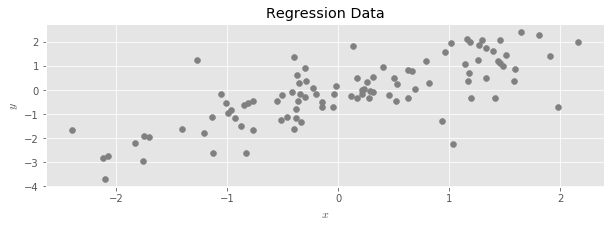

In [2]:
x, y = make_regression_data()

fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(x, y, color="grey")
ax.set_title("Regression Data")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

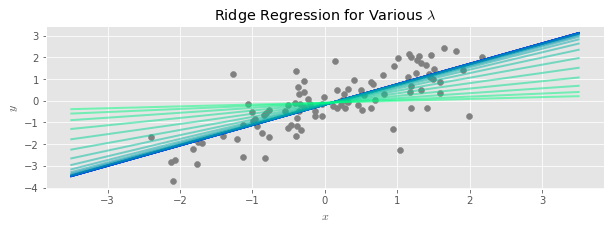

In [3]:
colors = plt.cm.winter(np.linspace(0, 1, 25))

fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(x, y, color="grey")
for lam, color in zip(np.logspace(-3, 3, num=25), colors):
    r = RidgeRegression(lam=lam).fit(x, y)
    plot_ridge_predictions(ax, r, color=color, alpha=0.5)
ax.set_title("Ridge Regression for Various $\lambda$")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

In [4]:
x_rand = add_multiplicitive_random_noise(x, sd=1.0)

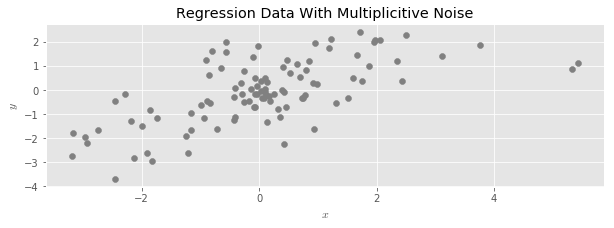

In [5]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(x_rand, y, color="grey")
ax.set_title("Regression Data With Multiplicitive Noise")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

In [6]:
mask = is_tail_point(x)
color = np.array(["grey", "green"])[mask.astype(int)]

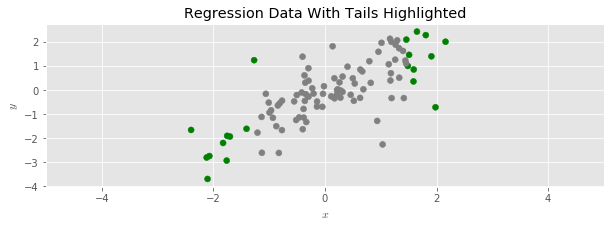

In [7]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(x, y, color=color)
ax.set_xlim(-5, 5)
ax.set_title("Regression Data With Tails Highlighted")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

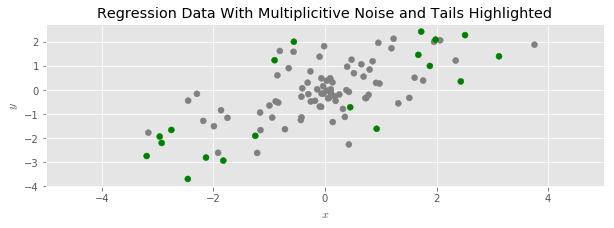

In [8]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(x_rand, y, color=color)
ax.set_xlim(-5, 5)
ax.set_title("Regression Data With Multiplicitive Noise and Tails Highlighted")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

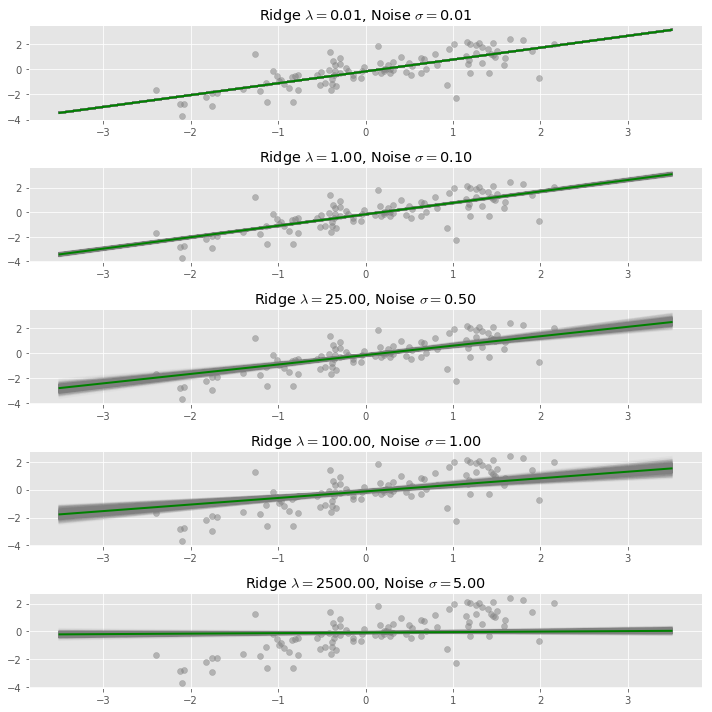

In [9]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10))
sds = [0.01, 0.1, 0.5, 1.0, 5.0]

for ax, sd in zip(axs, sds):
    #rigde_constant = 
    ax.scatter(x, y, color="grey", alpha=0.5)
    for i in range(500):
        r_preterbed = fit_preterbed_data_regression(x, y, sd=sd)
        plot_ridge_predictions(ax, r_preterbed, color="grey", alpha=0.05)
    r = RidgeRegression(lam=len(x)*sd**2).fit(x, y)
    plot_ridge_predictions(ax, r, color="green", linewidth=2)
    ax.set_title("Ridge $\lambda = ${:4.2f}, Noise $\sigma = ${:2.2f}".format(
        len(x)*sd**2, sd))
    
fig.tight_layout()

## Proof

### Statement of the Problem

The linear regression problem is to find a vector $\hat \beta$ that minmizes

$$ \hat \beta = argmin_\beta \left| y - X \beta \right|^2 $$

Where $X$ is a matrix of predictiors (the design matrix) and $y$ is a vector of responses.  The idea is that we would like to predict $y$ from $X$ by using a linear function in the columns of $X$.

In our setup, we scale each entry of $X$ by a small amount of gaussian noise before regressing:

$$ x_{ij} \rightarrow \epsilon_{ij} x_{ij} $$

where $\epsilon \sim N(1, \sigma)$.

Of course, we get a different line for each choice of random $\epsilon$; we are interested in what happens *on average*.  That is, we are interested in the solution vector $\beta$ that is the *expectation* under this process

$$ \hat \beta \sim argmin_\beta E_G \left[ \left| y - (G * X) \beta  \right|^2 \right] $$

In this equation, $G$ represents a matrix of random gaussian noise, the $*$ operator is elementwise multiplication of matricies, and $E_G$ marginalizes out the contributions of the noise.

Let's begin by expanding out the quantity inside the expectation:

$$\begin{align*}
\left| y - (G * X) \beta  \right|^2 &= \left( y - (G * X) \beta \right)^t \left( y - (G * X) \beta \right) \\
&= y^t y - 2 y^t (G * X) \beta + \beta^t (G * X)^t (G * X) \beta
\end{align*}$$

### Computing the Quadratic Term

We focus on the last term for the moment, say we name

$$ M = (G * X)^t (G * X) $$

Now a single entry in this matrix is

$$ m_{ij} = \sum_{k} \epsilon_{ki} \epsilon_{kj} x_{ki} x_{kj} $$

which in expectation is

$$ E_G \left[ m_{ij} \right] = \sum_{k} E \left[ \epsilon_{ki} \epsilon_{kj} \right] x_{ki} x_{kj} $$

If $i \neq j$, then $\epsilon_{ki}$ and $\epsilon_{kj}$ are independent random varaibles both drawn from a $N(1, \sigma)$, so

$$ E \left[ \epsilon_{ki} \epsilon_{kj} \right] = 1 \ \text{for} i \neq j $$

For $i = j$, we can compute

$$ E \left[ \epsilon_{ki}^2 \right] = E \left[ (\epsilon_{ki} - 1)^2 + 2 \epsilon_{ki} - 1 \right] = \sigma^2 + 2 - 1 = \sigma^2 + 1 $$

So all together

$$ E \left[ \epsilon_{ki} \epsilon_{kj} \right] = \begin{cases} \sigma^2 + 1 & \text{if} \ i = j \\ 1 & \text{otherwise} \end{cases} $$

This means that

$$ E[M] = \left( \mathbb{1} + diag(\sigma^2) \right) * X^t X  = X^t X + diag(\sigma^2) X^t X $$

Where $\mathbb{1}$ is a matrix with a $1$ in every entry.

### Putting it All Together

Now we can compute the expectation of our entire quantity

$$\begin{align*}
E \left[ \left| y - (G * X) \beta  \right|^2 \right] &= E \left[ y^t y - 2 y^t (G * X) \beta + \beta^t (G * X)^t (G * X) \right] \\
&= y^t y - 2 y^t (E[G] * X) \beta + \beta^t E \left[ M \right] \beta \\
&= y^t y - 2 y^t X \beta + \beta^t X^t X \beta + \beta^t diag(\sigma^2) X^t X \beta \\
&= \left| y - X \beta \right|^2 + \beta^t diag(\sigma^2) X^t X \beta \\
&= \left| y - X \beta \right|^2 + \sigma^2 \left| \Gamma \beta \right|^2
\end{align*}$$

Where $\Gamma = \sqrt{ diag \left( X^t X \right) }$.

So, overall, our original problem can be restated as

$$ \hat \beta \sim argmin_\beta \left( \left| y - X \beta \right|^2 + \sigma^2 \left| \Gamma \beta \right|^2 \right) $$

Which we recognise as linear regression with a tikhonov regularization term, with the regularization strength depending on the amount of noise we add to each predictor: more noise results in stronger regularization.

### Ridge Regression

In ridge regression, we always ensure that our predictors are standardized before regressing.  That is, we ensure that $\frac{1}{N}diag(X^t X) = I$.  If we impose this assumption to our resulting regularization problem, we get

$$ \hat \beta \sim argmin_\beta \left( \left| y - X \beta \right|^2 + N \sigma^2 \left|\beta \right|^2 \right) $$

That is, under the usual assumptions of unit variance, our add-noise procedure is *in expectation* equivelent to ridge regression with a regularization strenght *equal* to $N \sigma^2$.